In [1]:
"""Import libraries"""
from typing import Optional, Union, Tuple, List, Callable, Dict
import torch
from diffusers import StableDiffusionPipeline, DiffusionPipeline, PNDMScheduler
import numpy as np
import abc
import ptp_utils
import imageio
import os
import csv

### Access information

In [2]:
# Access information
description_file_path = os.path.join(os.path.dirname(os.getcwd()),"descriptions/340_final_text_list.csv") # csv path of concept-word sets
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device("cuda:2") if torch.cuda.is_available() else torch.device("cpu")
ldm_stable = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0").to(device)
ldm_stable.scheduler = PNDMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", set_alpha_to_one=False, skip_prk_steps=True, steps_offset=1)
model_version = "sd_xl_base_1_0"
tokenizer = ldm_stable.tokenizer

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

### Define functions

In [3]:
# --------------------------- #
data = []
with open(description_file_path, "r") as f:
    render = csv.reader(f)
    for row in render:
        data.append(row)
num_list = np.arange(1, 11).astype(str)
data = [row for row in data if row != []]
data = [row[0] for row in data if not any(num in row[0] for num in num_list)]
data[0] = data[0].replace("\ufeff","")

CONCEPTS = data
# --------------------------- #

def update_alpha_time_word(alpha, bounds: Union[float, Tuple[float, float]], prompt_ind: int, 
                           word_inds: Optional[torch.Tensor]=None):
    if type(bounds) is float:
        bounds = 0, bounds
    start, end = int(bounds[0] * alpha.shape[0]), int(bounds[1] * alpha.shape[0])
    if word_inds is None:
        word_inds = torch.arange(alpha.shape[2])
    alpha[:start, prompt_ind, word_inds] = 0
    alpha[start: end, prompt_ind, word_inds] = 1
    alpha[end:, prompt_ind, word_inds] = 0
    return alpha

def get_time_words_attention_alpha(prompts, num_steps,
                                   cross_replace_steps: Union[float, Dict[str, Tuple[float, float]]],
                                   tokenizer, max_num_words=77):
    if type(cross_replace_steps) is not dict:
        cross_replace_steps = {"default_": cross_replace_steps}
    if "default_" not in cross_replace_steps:
        cross_replace_steps["default_"] = (0., 1.)
    
    alpha_time_words = torch.zeros(num_steps+1, len(prompts), max_num_words)
    for i in range(len(prompts)):
        alpha_time_words = update_alpha_time_word(alpha_time_words, cross_replace_steps["default_"], i)
    
    for key, item in cross_replace_steps.items():
        if key != "default_":
            inds = [get_word_inds(prompts[i], key, tokenizer) for i in range(len(prompts))]
            for i, ind in enumerate(inds):
                if len(ind) > 0:
                    alpha_time_words = update_alpha_time_word(alpha_time_words, item, i, ind)
    
    alpha_time_words = alpha_time_words.reshape(num_steps+1, len(prompts), 1, 1, max_num_words)
    return alpha_time_words

def get_word_inds(text: str, word_place, tokenizer):
    """Return the index of 'word_place' in the tokenzied 'text'
       cf) 'word_place' may appear multiple times in the 'text'"""
    split_text = text.split(" ")
    if type(word_place) is str:
        word_place = word_place.strip()
        if len(word_place.split(" ")) == 1:
            word_place = [i for i, word in enumerate(split_text) if word_place == word]
        else:
            word_place_splited = word_place.split(" ")
            word_place_ = []
            for i, word in enumerate(split_text):
                if word == word_place_splited[0]:
                    if split_text[i:i+len(word_place_splited)] == word_place_splited:
                        word_place_ += [j for j in range(i, i+len(word_place_splited))]
            word_place = word_place_
    elif type(word_place) is int:
        word_place = [word_place]
    out = []
    if len(word_place) > 0:
        words_encode = [tokenizer.decode([item]).strip("#") for item in tokenizer.encode(text)][1:-1]
        cur_len, ptr = 0, 0
        for i in range(len(words_encode)):
            cur_len += len(words_encode[i])
            if ptr in word_place:
                out.append(i + 1)
            if cur_len >= len(split_text[ptr]):
                ptr += 1
                cur_len = 0
    return np.array(out)

def get_equalizer(text: str, word_select: Union[int, Tuple[int, ...]], values: Union[List[float],
                  Tuple[float, ...]]):
    """"Equalizer for attention reweighting"""
    if type(word_select) is int or type(word_select) is str:
        word_select = (word_select, )
    equalizer = torch.ones(len(values), 77)
    values = torch.tensor(values, dtype=torch.float32)
    for word in word_select:
        inds = get_word_inds(text, word, tokenizer)
        equalizer[:, inds] = values
    return equalizer


def init_latent(latent, model, height, width, generator, batch_size):
    if latent is None:
        latent = torch.randn(
            (1, model.unet.config.in_channels, height // 8, width // 8),
            generator=generator
        )
    latents = latent.expand(batch_size, model.unet.config.in_channels, height // 8, width // 8).to(model.device)
    return latent, latents

@torch.no_grad()
def text2image_ldm_stable(
    model,
    prompt: List[str],
    controller,
    num_inference_steps: int = 50,
    guidance_scale: float = 7.5,
    generator: Optional[torch.Generator] = None,
    latent: Optional[torch.FloatTensor] = None,
    negative_prompt: bool = False,
): 
    
    register_attention_control(model, controller) # modifies a forward pass of the model
    height = width = model.unet.config.sample_size * model.vae_scale_factor
    original_size = (height, width)
    target_size = (height, width)
    crops_coords_top_left = (0, 0)

    batch_size = len(prompt)
    do_classifier_free_guidance = guidance_scale > 1.0

    # Encode input prompt
    (prompt_embeds, negative_prompt_embeds, pooled_prompt_embeds, negative_pooled_prompt_embeds) = model.encode_prompt(
         prompt=prompt,
         prompt_2=None,
         device=model.device,
         num_images_per_prompt=1,
         do_classifier_free_guidance=do_classifier_free_guidance,
     )

    # Prepare timesteps
    model.scheduler.set_timesteps(num_inference_steps, device=model.device)

    # Prepare latent variables
    num_channels_latents = model.unet.config.in_channels
    latents = model.prepare_latents(
        batch_size,
        num_channels_latents,
        height,
        width,
        prompt_embeds.dtype,
        model.device,
        generator,
    )

    # Prepare extra step kwargs
    extra_step_kwargs = model.prepare_extra_step_kwargs(generator, 0.0)

    # Prepare added time ids & embeddings
    add_text_embeds = pooled_prompt_embeds
    add_time_ids = model._get_add_time_ids(
        original_size, crops_coords_top_left, target_size, dtype=prompt_embeds.dtype,
        text_encoder_projection_dim=model.text_encoder_2.config.projection_dim
    )
    negative_add_time_ids = add_time_ids

    # When using classifier_free_guidance,
    if do_classifier_free_guidance:
        prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds], dim=0)
        add_text_embeds = torch.cat([negative_pooled_prompt_embeds, add_text_embeds], dim=0)
        add_time_ids = torch.cat([negative_add_time_ids, add_time_ids], dim=0)

    prompt_embeds = prompt_embeds.to(device)
    add_text_embeds = add_text_embeds.to(device)
    add_time_ids = add_time_ids.to(device).repeat(batch_size, 1)

    added_cond_kwargs = {"text_embeds": add_text_embeds, "time_ids": add_time_ids}

    # Apply denosing process
    for i, t in enumerate(model.scheduler.timesteps):
        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = model.scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        noise_pred = model.unet(latent_model_input, t, encoder_hidden_states=prompt_embeds,
                                added_cond_kwargs=added_cond_kwargs, ).sample

        # perform guidance
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # x_t -> x_t-1
        latents = model.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

        # callback
        latents = controller.step_callback(latents)
    
    needs_upcasting = model.vae.dtype == torch.float16 and model.vae.config.force_upcast

    if needs_upcasting:
        model.upcast_vae()
        latents = latents.to(next(iter(model.vae.post_quant_conv.parameters())).dtype)

    image = model.vae.decode(latents / model.vae.config.scaling_factor, return_dict=False)[0]
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).numpy()
    image = (image * 255).astype(np.uint8)

    # cast back to fp16 if needed
    if needs_upcasting:
        model.vae.to(dtype=torch.float16)
    
    # Add watermark on the image
    # image = model.watermark.apply_watermark(image)
    # image = model.image_processor.postprocess(image, output_type="pil")

    model.maybe_free_model_hooks()

    return image, latent


def register_attention_control(model, controller): 
    def ca_forward(self, place_in_unet, count):
        to_out = self.to_out
        if type(to_out) is torch.nn.modules.container.ModuleList:
            to_out = to_out[0]
        else:
            to_out = self.to_out
        
        def forward(hidden_states, encoder_hidden_states=None, attention_mask=None, temb=None,):
            is_cross = encoder_hidden_states is not None
            layer = count // 2 # layer index

            residual = hidden_states

            if self.spatial_norm is not None:
                hidden_states = self.spatial_norm(hidden_states, temb)
            
            input_ndim = hidden_states.ndim

            if input_ndim == 4:
                batch_size, channel, height, width = hidden_states.shape
                hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)
            
            batch_size, sequence_length, _ = (
                hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
            )
            attention_mask = self.prepare_attention_mask(attention_mask, sequence_length, batch_size)

            if self.group_norm is not None:
                hidden_states = self.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)
            
            query = self.to_q(hidden_states)

            if encoder_hidden_states is None:
                encoder_hidden_states = hidden_states
            elif self.norm_cross:
                encoder_hidden_states = self.norm_encoder_hidden_states(encoder_hidden_states)

            key = self.to_k(encoder_hidden_states) # (is_cross) encoder_hidden_states.shape = (2*batch_size, 77, 768)
            value = self.to_v(encoder_hidden_states)
            wo_head = key.shape[0] # 2*batch_size

            query = self.head_to_batch_dim(query)
            key = self.head_to_batch_dim(key) # (is_cross) (2*batch_size*h, 77, 40)
            value = self.head_to_batch_dim(value) # (is_cross) (2*batch_size*h, 77, 40)
            w_head = key.shape[0] # 2*batch_size*h
            
            attention_probs = self.get_attention_scores(query, key, attention_mask) # shape: [2*h, res*res, 77]
            attention_probs = controller(attention_probs, is_cross, place_in_unet, layer)  # Focus here!
            # --------------------------------------------------- #
            # controller(result, is_cross, place_in_unet)
            # --------------------------------------------------- #

            hidden_states = torch.bmm(attention_probs, value)
            hidden_states = self.batch_to_head_dim(hidden_states)

            # linear proj
            hidden_states = to_out(hidden_states)

            if input_ndim == 4:
                hidden_states = hidden_states.transpose(1, 2).view(batch_size, channel, height, width)

            if self.residual_connection:
                hidden_states = hidden_states + residual
            
            hidden_states = hidden_states / self.rescale_output_factor

            return hidden_states
        return forward
    
    class DummyController:

        def __call__(self, *args):
            return args[0]
        
        def __init__(self):
            self.num_att_layers = 0
    
    if controller is None:
        controller = DummyController()
    
    def register_recr(net_, count, place_in_unet):
        if net_.__class__.__name__ == "Attention":
            net_.forward = ca_forward(net_, place_in_unet, count)
            return count + 1
        elif hasattr(net_, 'children'):
            for net__ in net_.children():
                count = register_recr(net__, count, place_in_unet)
        return count

    att_count = 0
    sub_nets = model.unet.named_children()
    for net in sub_nets:
        if "down" in net[0]:
            att_count += register_recr(net[1], 0, "down")
        elif "up" in net[0]:
            att_count += register_recr(net[1], 0, "up")
        elif "mid" in net[0]:
            att_count += register_recr(net[1], 0 , "mid")
    
    controller.num_att_layers = att_count

### Define attention controls for reweighting cross-attention heads using HRVs

In [4]:
class AttentionControl(abc.ABC):

    def step_callback(self, x_t):
        return x_t
    
    def between_steps(self):
        return
    
    @property
    def num_uncond_att_layers(self):
        return 0
    
    @abc.abstractmethod
    def forward(self, attn, is_cross: bool, place_in_unet: str, layer):
        raise NotImplementedError

    def __call__(self, attn, is_cross: bool, place_in_unet: str, layer):
        if self.cur_att_layer >= self.num_uncond_att_layers:
            h = attn.shape[0] 
            attn[h // 2:] = self.forward(attn[h // 2:], is_cross, place_in_unet, layer) # Save attention map with text conditions
        self.cur_att_layer += 1
        if self.cur_att_layer == self.num_att_layers + self.num_uncond_att_layers:
            self.cur_att_layer = 0
            self.cur_step += 1
            self.between_steps()
        return attn
    
    def reset(self):
        self.cur_step = 0
        self.cur_att_layer = 0
    
    def __init__(self):
        self.cur_step = 0
        self.num_att_layers = -1
        self.cur_att_layer = 0

class EmptyControl(AttentionControl):

    def forward(self, attn, is_cross: bool, place_in_unet: str, layer):
        return attn

class AttentionStore(AttentionControl):

    @staticmethod
    def get_empty_store():
        return {"down_cross": [], "mid_cross": [], "up_cross": [],
                "down_self": [],  "mid_self": [],  "up_self": []}
    
    def forward(self, attn, is_cross: bool, place_in_unet: str, layer):
        return attn
    
    def between_steps(self):
        if len(self.attention_store) == 0:
            self.attention_store = self.step_store
        else:
            for key in self.attention_store:
                for i in range(len(self.attention_store[key])):
                    self.attention_store[key][i] += self.step_store[key][i]
        self.step_store = self.get_empty_store()
    
    def get_average_attention(self):
        average_attention = {key: [item / self.cur_step for item in self.attention_store[key]] for key in self.attention_store}
        return average_attention
    
    def reset(self):
        super(AttentionStore, self).reset()
        self.step_store = self.get_empty_store()
        self.attention_store = {}
    
    def __init__(self):
        super(AttentionStore, self).__init__()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

class AttentionControlEdit(AttentionStore, abc.ABC):
    def step_callback(self, x_t):
        return x_t

    @abc.abstractmethod
    def replace_cross_attention(self, attn_replace, equlizer):
        raise NotImplementedError
    
    def forward(self, attn, is_cross: bool, place_in_unet: str, layer):
        super(AttentionControlEdit, self).forward(attn, is_cross, place_in_unet, layer)
        if is_cross:
            if self.standard_sd:
                return attn
            else:
                num_head = attn.shape[0] // (self.batch_size) # attn.shape: (batch_size * num_head, res^2, 77)
                attn = attn.reshape(self.batch_size, num_head, *attn.shape[1:])
                alpha_words = self.cross_replace_alpha[self.cur_step]
                for head in range(num_head):
                    attn[:, head] = self.replace_cross_attention(attn[:, head], place_in_unet, layer, head) * alpha_words[:, 0] + (1 - alpha_words[:, 0]) * attn[:, head]
                attn = attn.reshape(self.batch_size * num_head, *attn.shape[2:])
                return attn
        return attn
    
    def __init__(self, prompts, num_steps: int,
                 cross_replace_steps: Union[float, Tuple[float, float], Dict[str, Tuple[float, float]]]):
        super(AttentionControlEdit, self).__init__()
        self.batch_size = len(prompts)
        self.cross_replace_alpha = get_time_words_attention_alpha(prompts, num_steps, cross_replace_steps, tokenizer).to(device)

class AttentionReweight(AttentionControlEdit):
    """Reweight specific tokens in the attention map"""
    def replace_cross_attention(self, attn, place_in_unet=None, layer=None, head=None):
        head_pos = f"{place_in_unet}, layer: {layer}, head: {head}"
        desired_concept_rescaler = self.category_vectors[CONCEPTS.index(self.adjusting_direction[0]), np.where(self.head_index == head_pos)[0][0]]
        undesired_concept_rescaler = self.category_vectors[CONCEPTS.index(self.adjusting_direction[1]), np.where(self.head_index == head_pos)[0][0]]
        if self.clamping_value is None:
            rescale_factor = (self.equalizers[0][:, None, :] + self.equalizers[1][:, None, :] * (desired_concept_rescaler * 2 - undesired_concept_rescaler * 1)) # concept adjusting
        else:
            rescale_factor = (self.equalizers[0][:, None, :] + self.equalizers[1][:, None, :] * (min(desired_concept_rescaler, self.clamping_value) * 2 - min(undesired_concept_rescaler, self.clamping_value) * 1)) # concept adjusting with clamping
        attn = attn * rescale_factor
        return attn
    
    def __init__(self, prompts, num_steps: int, cross_replace_steps, equalizers, adjusting_direction=None, 
                 category_vectors=None, head_index=None, standard_sd=None, clamping_value=None):
        super(AttentionReweight, self).__init__(prompts, num_steps, cross_replace_steps)
        self.adjusting_direction = adjusting_direction
        self.equalizers = equalizers
        self.cross_replace_steps = cross_replace_steps
        self.category_vectors = category_vectors
        self.head_index = head_index
        self.standard_sd = standard_sd
        self.clamping_value = clamping_value

"""run and display code"""
def run_and_display(prompts, controller, latent=None, generator=None, verbose=True):
    images, x_t = text2image_ldm_stable(ldm_stable, prompts, controller, latent=latent, num_inference_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, generator=generator) 
    if verbose:
        ptp_utils.view_images(images)
    return images, x_t

print(CONCEPTS)

['Animals', 'Plants', 'Fruits and Vegetables', 'People', 'Vehicles', 'Buildings', 'Furniture', 'Electronics', 'Clothing', 'Accessories', 'Tools', 'Toys', 'Food and Beverages', 'Books and Documents', 'Sports Equipment', 'Musical Instruments', 'Written Characters', 'Color', 'Shape', 'Texture', 'Size', 'Counting', 'Image Style', 'Material', 'Lighting Conditions', 'Facial Expressions', 'Facial Features', 'Poses and Gestures', 'Nature Scenes', 'Weather Conditions', 'Time of Day', 'Geo-locations', 'Brand Logos', 'Geometric Patterns']


### Reduce misinterpretation by applying concept adjusting to Stable Diffusion

Prompt: A rose-colored vase
Selected token: rose-colored
Desired concept: Color
Undesired concept: Plants
(Top) Standard SDXL, (Bottom) SDXL-HRV
Seeds: [1]


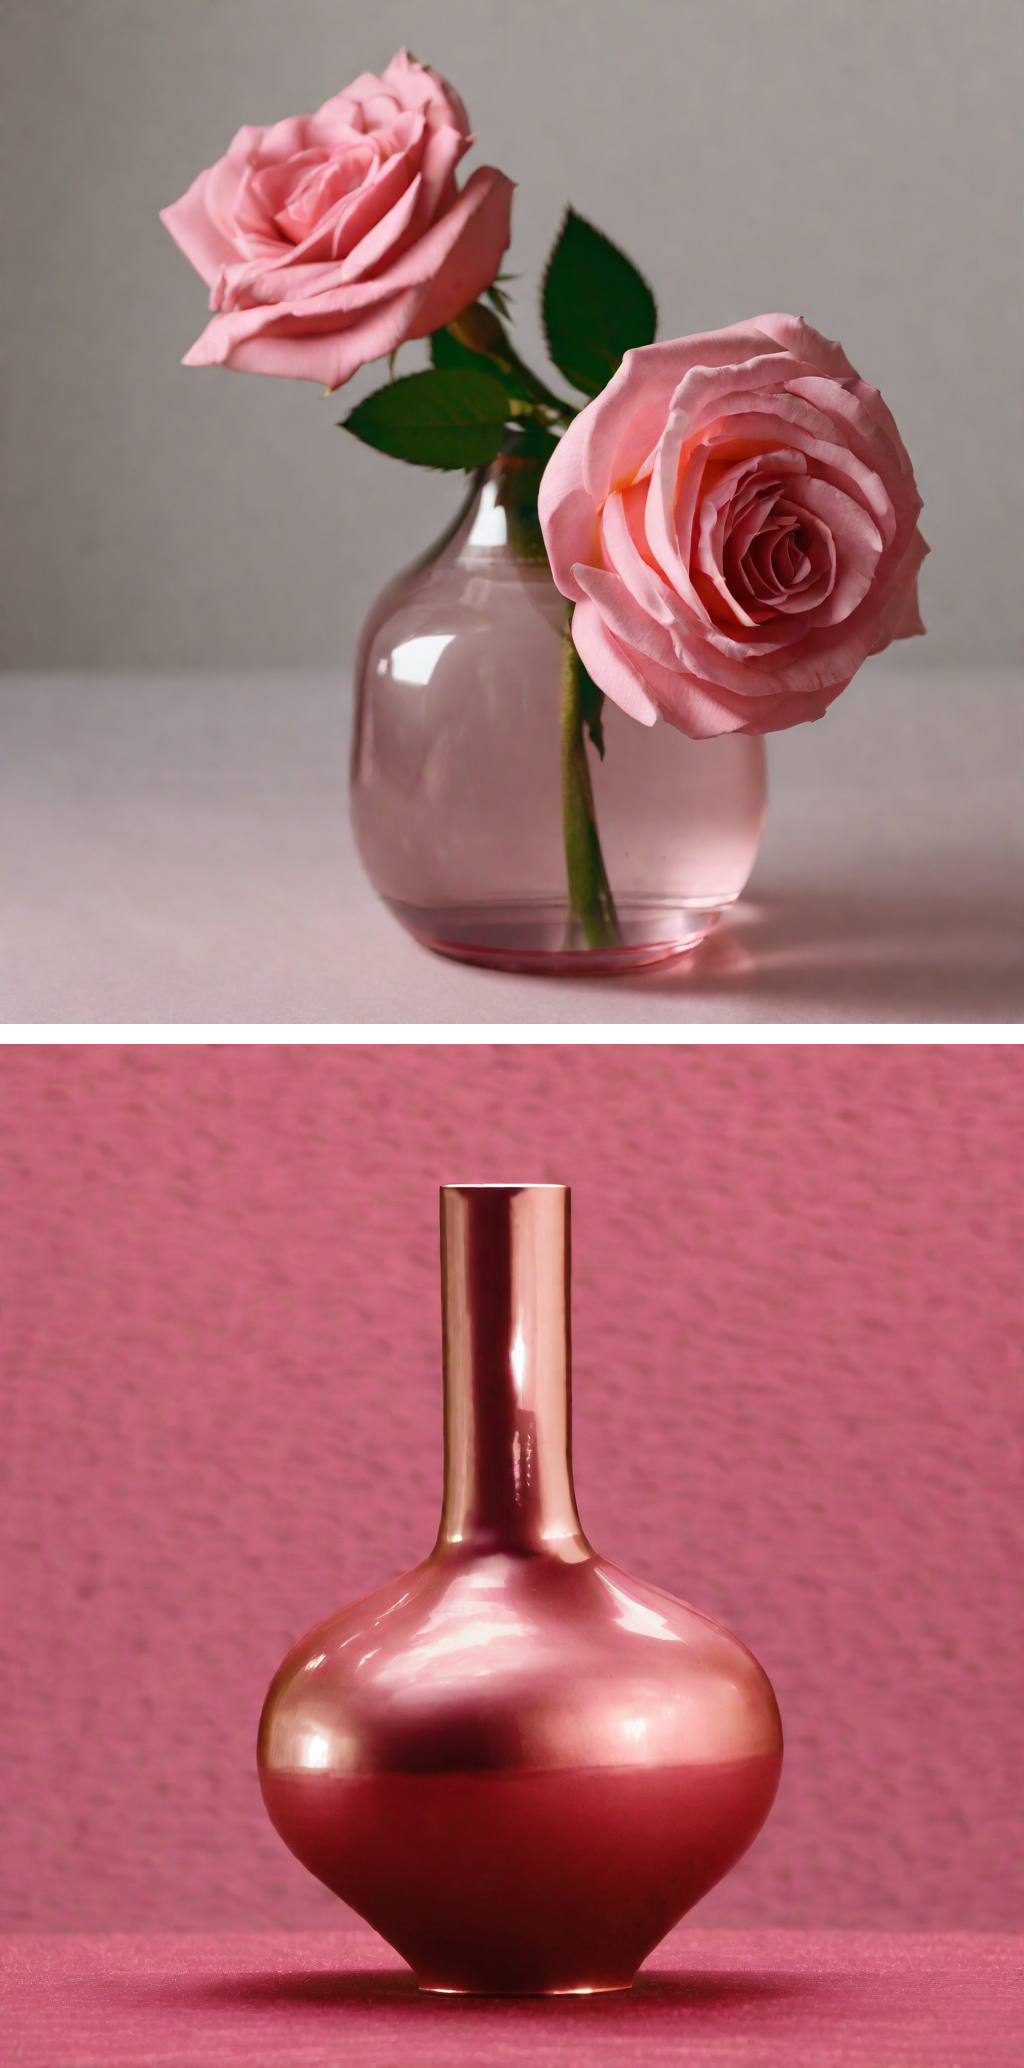

In [5]:
"""This code block will save the generated images of SDXL and SDXL-HRV"""
# Generation timsteps for applying concept adjusing
reweight_steps = [0, 1.01] 

# The following two files can be obtained from "extract_head_relevance_vectors.ipynb"
category_vectors = np.load(os.path.join(os.path.dirname(os.getcwd()), f"final_result/category_vectors_epoch_1_to_1_neg_prompt_False_merged_340_final_text_descriptions_{model_version}.npy"))
head_index = np.load(os.path.join(os.path.dirname(os.getcwd()), f"./final_result/head_index_epoch_1_to_1_neg_prompt_False_merged_340_final_text_descriptions_{model_version}.npy"))

# --- Change these values --- #
prompts = ["A rose-colored vase"]
selected_token = "rose-colored"
desired_concept = "Color"
undesired_concept = "Plants"
adjusting_direction  =[desired_concept, undesired_concept]
output_dir = f"./reduce_misinterpretation_outputs/sdxl_prompt_01_{prompts[0].replace(' ', '_')}"
seeds = [1]
clamping_value = 9 # None for no clamping
# --------------------------- #

os.makedirs(os.path.join(output_dir, f"standard_sdxl"), exist_ok=True)
os.makedirs(os.path.join(output_dir, f"sdxl-hrv"), exist_ok=True)

images = []
for idx, seed in enumerate(seeds):
    g_cpu = torch.Generator().manual_seed(seed)
    equalizers = None
    standard_sd = True
    controller = AttentionReweight(prompts, NUM_DIFFUSION_STEPS, cross_replace_steps=reweight_steps,
                                   equalizers=equalizers, adjusting_direction=adjusting_direction, category_vectors=category_vectors,
                                   head_index=head_index, standard_sd=standard_sd)
    image = run_and_display(prompts, controller, generator=g_cpu, verbose=False)[0]
    imageio.imwrite(f"{output_dir}/standard_sdxl/{seed}.png", image[0])
    images.append(image)
for idx, seed in enumerate(seeds):
    g_cpu = torch.Generator().manual_seed(seed)
    standard_sd = False

    equalizers = []
    zero_prompt_equalizer = get_equalizer(prompts[0], (selected_token), (0,)).to(device)
    equalizers.append(zero_prompt_equalizer)
    equalizers.append(1 - zero_prompt_equalizer)

    controller = AttentionReweight(prompts, NUM_DIFFUSION_STEPS, cross_replace_steps=reweight_steps,
                                   equalizers=equalizers, adjusting_direction=adjusting_direction, category_vectors=category_vectors,
                                   head_index=head_index, standard_sd=standard_sd, clamping_value=clamping_value)
    
    image = run_and_display(prompts, controller, generator=g_cpu, verbose=False)[0]
    imageio.imwrite(f"{output_dir}/sdxl-hrv/{seed}.png", image[0])
    images.append(image)

print("Prompt:", prompts[0])
print("Selected token:", selected_token)
print("Desired concept:", desired_concept)
print("Undesired concept:", undesired_concept)
print("(Top) Standard SDXL, (Bottom) SDXL-HRV")
print("Seeds:", seeds)
images = np.concatenate(images, axis=0)
ptp_utils.view_images(images, num_rows=2)